# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-beta.new.362.fix.360'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Please set verbose=2 to see the detailed citation list.




### The number of cases (JHU style)
The main dataset is that of the number of cases. This includes "Confirmed", "Infected", "Recovered" and "Fatal". "Infected" was calculated as "Confirmed - Recovered - Fatal".

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [6]:
# Citation of COVID-19 Data Hub: this was shown when `DataLoader.jhu(verbose=True)
# print(data_loader.covid19dh_citation)

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
343984,2020-11-24,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343985,2020-11-25,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343986,2020-11-26,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343987,2020-11-27,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343988,2020-11-28,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
343984,2020-11-24,Colombia,Vichada,884,7,11,866
343985,2020-11-25,Colombia,Vichada,884,7,11,866
343986,2020-11-26,Colombia,Vichada,884,7,11,866
343987,2020-11-27,Colombia,Vichada,884,7,11,866
343988,2020-11-28,Colombia,Vichada,884,7,11,866


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
250,2020-11-24,38197,4123,479,33595
251,2020-11-25,38598,4152,482,33964
252,2020-11-26,39079,4189,485,34405
253,2020-11-27,39649,4348,488,34813
254,2020-11-28,39649,4348,488,34813


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-11-24,59825172,20191650,1414567,38218955,0.023645,0.638844,0.035691
2020-11-25,60443564,20380344,1426200,38637020,0.023596,0.639225,0.035599
2020-11-26,60962789,20553390,1436051,38973348,0.023556,0.639297,0.035538
2020-11-27,61080455,20581420,1439089,39059946,0.023561,0.639484,0.035534
2020-11-28,61080458,20699521,1439089,38941848,0.023561,0.637550,0.035638


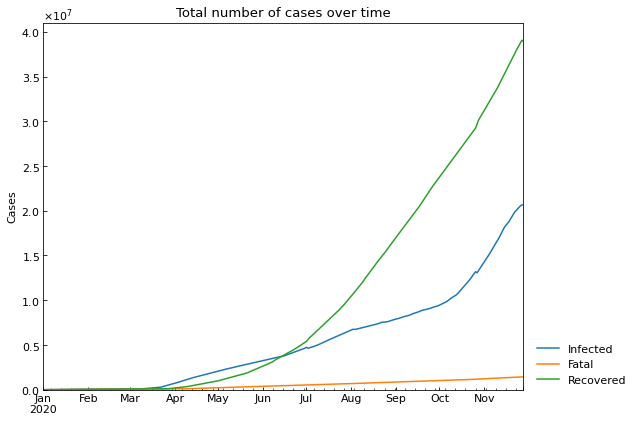

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan
If we have dataset for each country, we can use it optionally.

In [12]:
# Registered data in jhu_data
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
288,2020-11-23,134513,20277,1995,112241
289,2020-11-24,135741,20421,2014,113306
290,2020-11-25,137685,20944,2035,114706
291,2020-11-26,140189,21773,2064,116352
292,2020-11-27,142720,22527,2095,118098


In [13]:
# Download the dataset in Japan and show the citation
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [14]:
# Replace the dataset for Japan
jhu_data.replace(japan_data)
# Show the new records in Japan
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
287,2020-11-24,133929,18600,1989,113340
288,2020-11-25,135400,18674,2001,114725
289,2020-11-26,137261,18861,2022,116378
290,2020-11-27,139491,19305,2051,118135
291,2020-11-28,142068,19635,2074,120359


### Population in each country
Population values are necessary to calculate the number of susceptible people. Susceptible is a variable of SIR-derived models.

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
343984,2020-11-24,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343985,2020-11-25,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343986,2020-11-26,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343987,2020-11-27,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343988,2020-11-28,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
290038,COL,Colombia,Vichada,2020-11-24,107808
290039,COL,Colombia,Vichada,2020-11-25,107808
290040,COL,Colombia,Vichada,2020-11-26,107808
290041,COL,Colombia,Vichada,2020-11-27,107808
290042,COL,Colombia,Vichada,2020-11-28,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)
This will be used in [Usage (details: policy measures)](https://lisphilar.github.io/covid19-sir/usage_policy.html).

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
343984,2020-11-24,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343985,2020-11-25,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343986,2020-11-26,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343987,2020-11-27,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
343988,2020-11-28,884,866,11,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
343984,2020-11-24,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
343985,2020-11-25,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
343986,2020-11-26,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
343987,2020-11-27,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
343988,2020-11-28,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
328,2020-11-24,1,1,1,0,0,1,1,3,2,3,2,38.89
329,2020-11-25,1,1,1,0,0,1,1,3,2,3,2,38.89
330,2020-11-26,1,1,1,0,0,1,1,3,2,3,2,38.89
331,2020-11-27,1,1,1,0,0,1,1,3,2,3,2,38.89
332,2020-11-28,1,1,1,0,0,1,1,3,2,3,2,38.89


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
328,2020-11-24,1,1,1,0,0,1,1,3,2,3,2,38.89
329,2020-11-25,1,1,1,0,0,1,1,3,2,3,2,38.89
330,2020-11-26,1,1,1,0,0,1,1,3,2,3,2,38.89
331,2020-11-27,1,1,1,0,0,1,1,3,2,3,2,38.89
332,2020-11-28,1,1,1,0,0,1,1,3,2,3,2,38.89


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

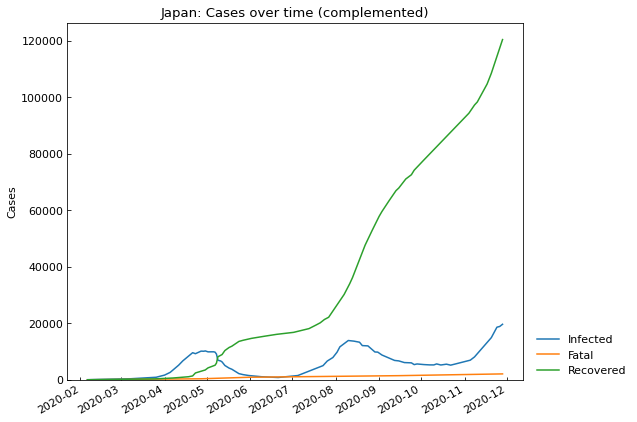

,Date,Confirmed,Infected,Fatal,Recovered
287,2020-11-24,133929,18600,1989,113340
288,2020-11-25,135400,18674,2001,114725
289,2020-11-26,137261,18861,2022,116378
290,2020-11-27,139491,19305,2051,118135
291,2020-11-28,142068,19635,2074,120359


In [26]:
record_df = snl.records()
record_df.tail()

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

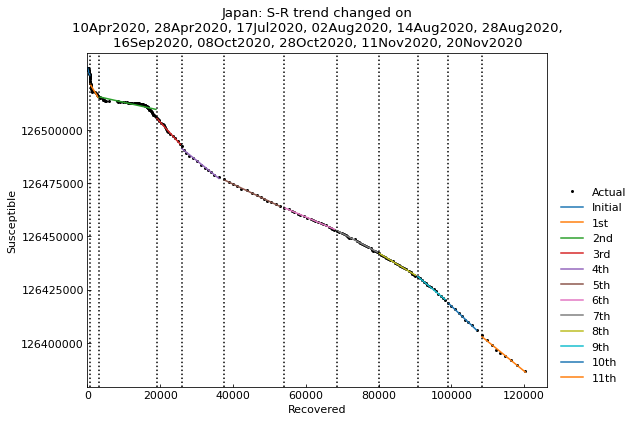

,Type,Start,End,Population
0th,Past,06Feb2020,09Apr2020,126529100
1st,Past,10Apr2020,27Apr2020,126529100
2nd,Past,28Apr2020,16Jul2020,126529100
3rd,Past,17Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,13Aug2020,126529100
5th,Past,14Aug2020,27Aug2020,126529100
6th,Past,28Aug2020,15Sep2020,126529100
7th,Past,16Sep2020,07Oct2020,126529100
8th,Past,08Oct2020,27Oct2020,126529100
9th,Past,28Oct2020,10Nov2020,126529100


In [27]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [28]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	11th phase (20Nov2020 - 28Nov2020): finished 2453 trials in 3 min  0 sec


	10th phase (14Aug2020 - 27Aug2020): finished  171 trials in 0 min 10 sec

	 6th phase (02Aug2020 - 13Aug2020): finished 2180 trials in 3 min  1 sec

	 5th phase (06Feb2020 - 09Apr2020): finished 2134 trials in 3 min  1 sec

	 1st phase (08Oct2020 - 27Oct2020): finished 2196 trials in 3 min  1 sec

	 7th phase (10Apr2020 - 27Apr2020): finished 2170 trials in 3 min  1 sec

	 0th phase (16Sep2020 - 07Oct2020): finished  371 trials in 0 min 20 sec

	 8th phase (28Oct2020 - 10Nov2020): finished  202 trials in 0 min 10 sec

	 3rd phase (28Aug2020 - 15Sep2020): finished  531 trials in 0 min 30 sec

	 9th phase (17Jul2020 - 01Aug2020): finished  382 trials in 0 min 20 sec

	 4th phase (11Nov2020 - 19Nov2020): finished 1674 trials in 1 min 40 sec

	 2nd phase (28Apr2020 - 16Jul2020): finished 2384 trials in 3 min  1 sec

Completed optimization. Total: 9 min  4 sec


In [29]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,09Apr2020,126529100,SIR-F,4.64,0.018475,0.000214,0.026208,0.005335,360,46,9,0.018,1170,0.235348,2134,3 min 1 sec
1st,Past,10Apr2020,27Apr2020,126529100,SIR-F,5.02,0.014388,0.000191,0.016455,0.003040,360,82,15,0.014,1309,0.163105,2170,3 min 1 sec
2nd,Past,28Apr2020,16Jul2020,126529100,SIR-F,0.36,0.083502,0.000154,0.005596,0.013925,360,17,44,0.084,1619,0.382911,2384,3 min 1 sec
3rd,Past,17Jul2020,01Aug2020,126529100,SIR-F,1.92,0.000434,0.000098,0.035020,0.018176,360,13,7,0.000,2550,0.023048,382,0 min 20 sec
4th,Past,02Aug2020,13Aug2020,126529100,SIR-F,1.55,0.000491,0.000097,0.026071,0.016747,360,14,9,0.000,2574,0.042770,2180,3 min 1 sec
5th,Past,14Aug2020,27Aug2020,126529100,SIR-F,0.79,0.000124,0.000228,0.019891,0.025003,360,9,12,0.000,1094,0.025192,171,0 min 10 sec
6th,Past,28Aug2020,15Sep2020,126529100,SIR-F,0.70,0.000583,0.000361,0.018314,0.025776,360,9,13,0.001,693,0.032696,531,0 min 30 sec
7th,Past,16Sep2020,07Oct2020,126529100,SIR-F,0.90,0.000299,0.000230,0.021942,0.024151,360,10,11,0.000,1085,0.022002,371,0 min 20 sec
8th,Past,08Oct2020,27Oct2020,126529100,SIR-F,1.03,0.000830,0.000226,0.026748,0.025666,360,9,9,0.001,1107,0.017438,2196,3 min 1 sec
9th,Past,28Oct2020,10Nov2020,126529100,SIR-F,1.44,0.005823,0.000180,0.029357,0.020070,360,12,8,0.006,1388,0.019352,202,0 min 10 sec


### Accuracy of estimation

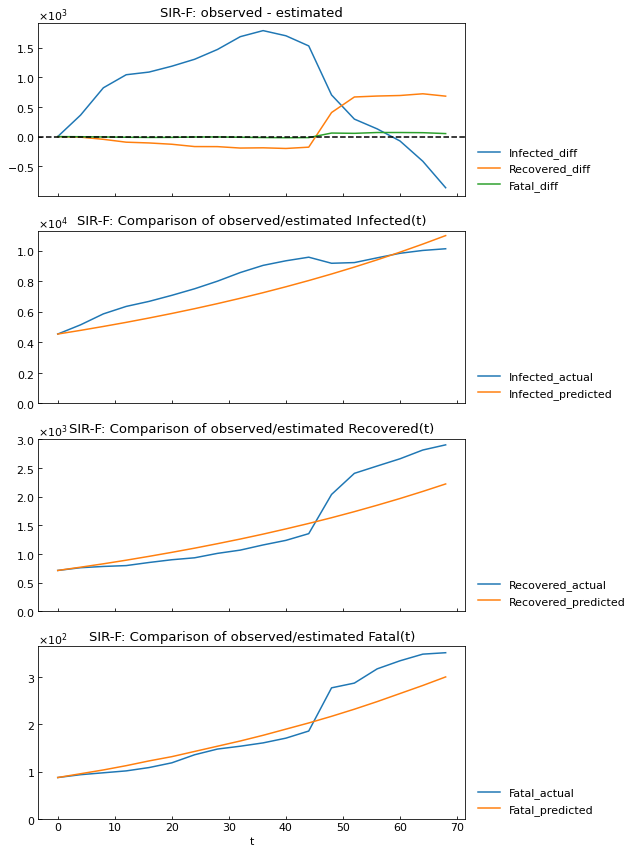

In [30]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
snl.get("Rt", phase="4th")

1.55

### Show parameter history

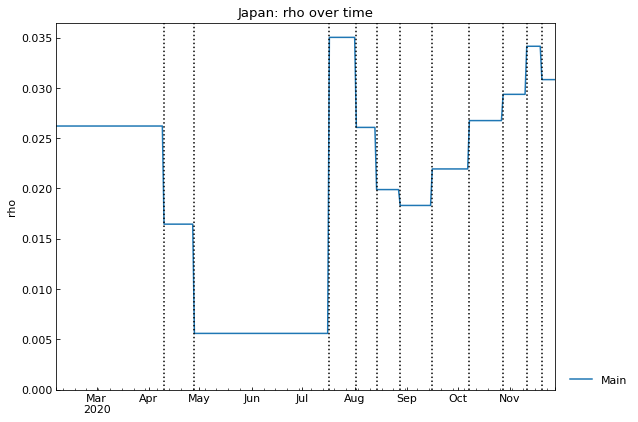

In [32]:
_ = snl.history(target="rho")

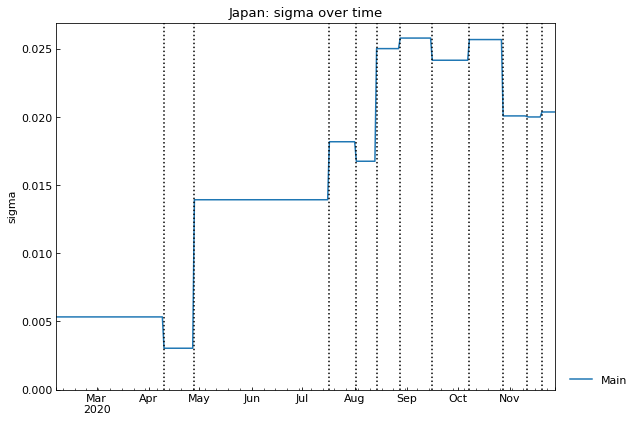

In [33]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

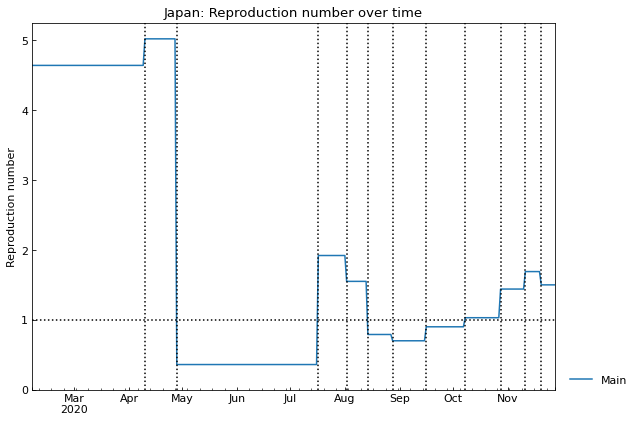

In [34]:
_ = snl.history(target="Rt")

### Simulate the number of cases

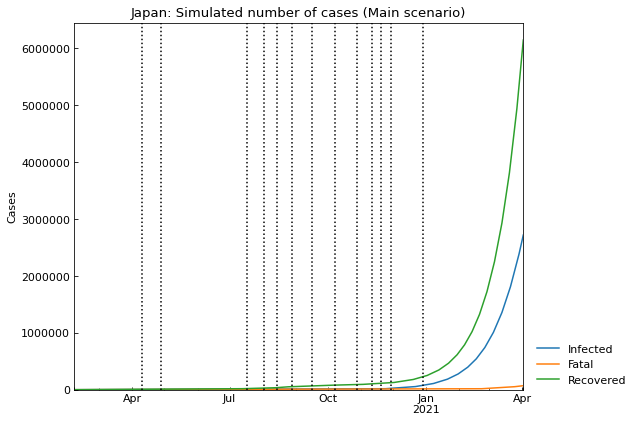

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,7762223,61169,2384674,5316380
418,2021-03-30,8042455,63408,2465249,5513798
419,2021-03-31,8331415,65721,2547833,5717861
420,2021-04-01,8629279,68112,2632430,5928737
421,2021-04-02,8936221,70580,2719041,6146600


In [35]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [36]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.020357802931184426

In [37]:
sigma_new = sigma_current * 2
sigma_new

0.04071560586236885

In [38]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  09Apr2020   126529100  SIR-F  4.64   
         1st      Past  10Apr2020  27Apr2020   126529100  SIR-F  5.02   
         2nd      Past  28Apr2020  16Jul2020   126529100  SIR-F  0.36   
         3rd      Past  17Jul2020  01Aug2020   126529100  SIR-F  1.92   
         4th      Past  02Aug2020  13Aug2020   126529100  SIR-F  1.55   
         5th      Past  14Aug2020  27Aug2020   126529100  SIR-F  0.79   
         6th      Past  28Aug2020  15Sep2020   126529100  SIR-F  0.70   
         7th      Past  16Sep2020  07Oct2020   126529100  SIR-F  0.90   
         8th      Past  08Oct2020  27Oct2020   126529100  SIR-F  1.03   
         9th      Past  28Oct2020  10Nov2020   126529100  SIR-F  1.44   
         10th     Past  11Nov2020  19Nov2020   126529100  SIR-F  1.69   
         11th     Past  20Nov2020  28Nov2020   126529100  SIR-F  1.50   
         12th   Future  29Nov2020  28Dec2020   126529100  SIR-F  1.50   
         13th   Future  29Dec2020  01Apr2021   126529100  SIR-F  1.50   
Medicine 0th      Past  06Feb2020  09Apr2020   126529100  SIR-F  4.64   
         1st      Past  10Apr2020  27Apr2020   126529100  SIR-F  5.02   
         2nd      Past  28Apr2020  16Jul2020   126529100  SIR-F  0.36   
         3rd      Past  17Jul2020  01Aug2020   126529100  SIR-F  1.92   
         4th      Past  02Aug2020  13Aug2020   126529100  SIR-F  1.55   
         5th      Past  14Aug2020  27Aug2020   126529100  SIR-F  0.79   
         6th      Past  28Aug2020  15Sep2020   126529100  SIR-F  0.70   
         7th      Past  16Sep2020  07Oct2020   126529100  SIR-F  0.90   
         8th      Past  08Oct2020  27Oct2020   126529100  SIR-F  1.03   
         9th      Past  28Oct2020  10Nov2020   126529100  SIR-F  1.44   
         10th     Past  11Nov2020  19Nov2020   126529100  SIR-F  1.69   
         11th     Past  20Nov2020  28Nov2020   126529100  SIR-F  1.50   
         12th   Future  29Nov2020  28Dec2020   126529100  SIR-F  1.50   
         13th   Future  29Dec2020  01Apr2021   126529100  SIR-F  0.75   

                   theta     kappa       rho     sigma  tau  1/gamma [day]  \
Scenario Phase                                                               
Main     0th    0.018475  0.000214  0.026208  0.005335  360             46   
         1st    0.014388  0.000191  0.016455  0.003040  360             82   
         2nd    0.083502  0.000154  0.005596  0.013925  360             17   
         3rd    0.000434  0.000098  0.035020  0.018176  360             13   
         4th    0.000491  0.000097  0.026071  0.016747  360             14   
         5th    0.000124  0.000228  0.019891  0.025003  360              9   
         6th    0.000583  0.000361  0.018314  0.025776  360              9   
         7th    0.000299  0.000230  0.021942  0.024151  360             10   
         8th    0.000830  0.000226  0.026748  0.025666  360              9   
         9th    0.005823  0.000180  0.029357  0.020070  360             12   
         10th   0.000174  0.000233  0.034135  0.019993  360             12   
         11th   0.000696  0.000211  0.030821  0.020358  360             12   
         12th   0.000696  0.000211  0.030821  0.020358  360             12   
         13th   0.000696  0.000211  0.030821  0.020358  360             12   
Medicine 0th    0.018475  0.000214  0.026208  0.005335  360             46   
         1st    0.014388  0.000191  0.016455  0.003040  360             82   
         2nd    0.083502  0.000154  0.005596  0.013925  360             17   
         3rd    0.000434  0.000098  0.035020  0.018176  360             13   
         4th    0.000491  0.000097  0.026071  0.016747  360             14   
         5th    0.000124  0.000228  0.019891  0.025003  360              9   
         6th    0.000583  0.000361  0.018314  0.025776  360              9   
         7th    0.000299  0.00023

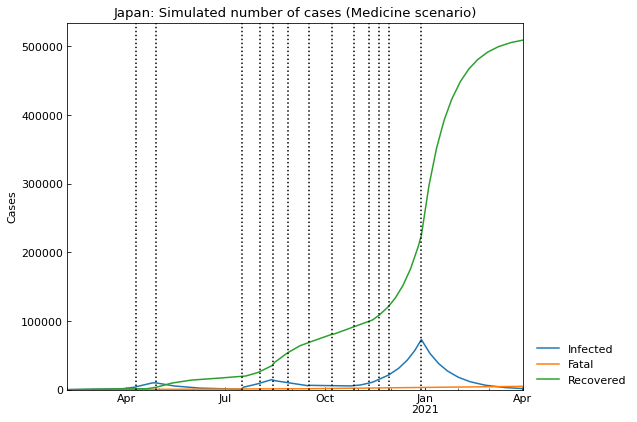

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,514590,4882,1836,507872
418,2021-03-30,514811,4884,1762,508165
419,2021-03-31,515022,4885,1691,508446
420,2021-04-01,515226,4887,1623,508716
421,2021-04-02,515421,4888,1558,508975


In [39]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [40]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,13th_Rt
Main,2719041,02Apr2021,8936221,2719041,70580,1.50
Medicine,72986,29Dec2020,515421,1558,4888,0.75


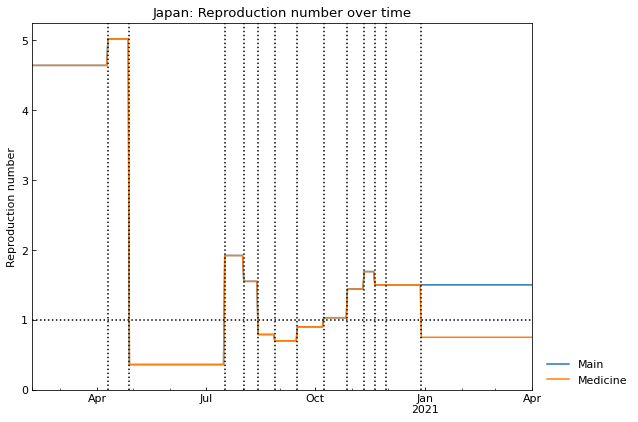

In [41]:
_ = snl.history(target="Rt")

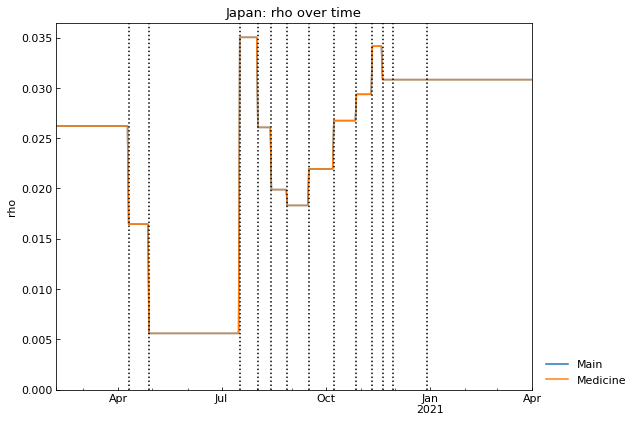

In [42]:
_ = snl.history(target="rho")

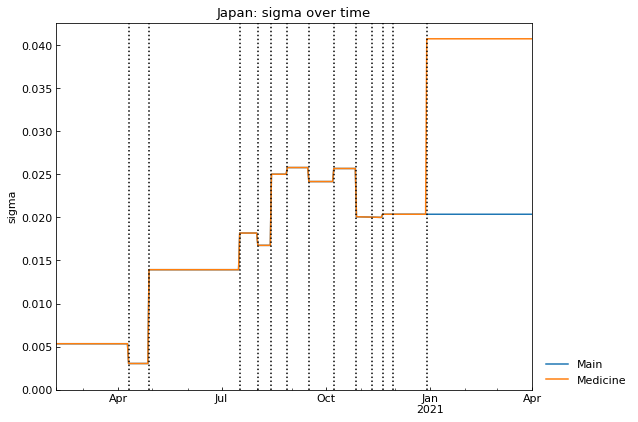

In [43]:
_ = snl.history(target="sigma")

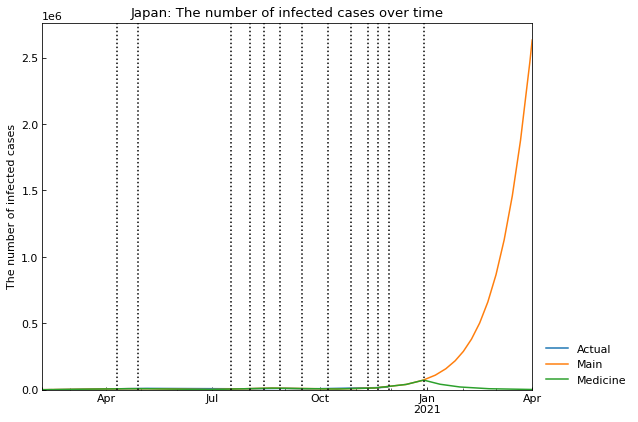

In [44]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

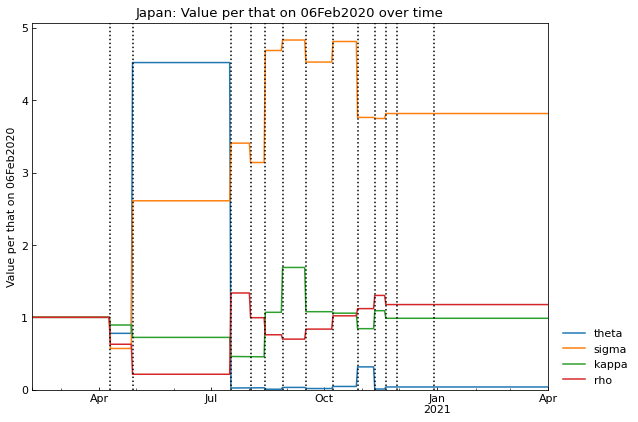

In [45]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [46]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	12th phase (20Nov2020 - 28Nov2020): finished 1771 trials in 3 min  2 sec


	 5th phase (01Sep2020 - 15Sep2020): finished  251 trials in 0 min 30 sec

	 6th phase (02Aug2020 - 13Aug2020): finished 1362 trials in 3 min  1 sec

	10th phase (14Aug2020 - 27Aug2020): finished 1366 trials in 3 min  2 sec

	 1st phase (08Oct2020 - 27Oct2020): finished 1291 trials in 3 min  2 sec

	 7th phase (06Feb2020 - 09Apr2020): finished  984 trials in 3 min  4 sec

	 2nd phase (28Aug2020 - 31Aug2020): finished  976 trials in 1 min 50 sec

	 3rd phase (10Apr2020 - 27Apr2020): finished 1359 trials in 3 min  2 sec

	11th phase (28Apr2020 - 16Jul2020): finished  921 trials in 3 min  3 sec

	 0th phase (16Sep2020 - 07Oct2020): finished 1346 trials in 3 min  1 sec

	 8th phase (28Oct2020 - 10Nov2020): finished 1632 trials in 3 min  1 sec

	 4th phase (11Nov2020 - 19Nov2020): finished 1967 trials in 3 min  1 sec

	 9th phase (17Jul2020 - 01Aug2020): finished 1902 trials in 3 min  1 sec

Completed optimization. Total: 12 min 12 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 0th phase (01Sep2020 - 28Nov2020): finished 6959 trials in 3 min  0 sec

Completed optimization. Total: 3 min  1 sec


In [47]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  09Apr2020  SIR-F  6.51  0.032305  0.000021   
              1st    10Apr2020  27Apr2020  SIR-F  4.88  0.042826  0.000002   
              2nd    28Apr2020  16Jul2020  SIR-F  0.70  0.215939  0.000004   
              3rd    17Jul2020  01Aug2020  SIR-F  1.82  0.003013  0.000001   
              4th    02Aug2020  13Aug2020  SIR-F  1.53  0.002284  0.000001   
              5th    14Aug2020  27Aug2020  SIR-F  0.93  0.002093  0.000001   
              6th    28Aug2020  31Aug2020  SIR-F  0.74  0.000867  0.000021   
              7th    01Sep2020  15Sep2020  SIR-F  0.70  0.019841  0.000002   
              8th    16Sep2020  07Oct2020  SIR-F  0.90  0.018771  0.000001   
              9th    08Oct2020  27Oct2020  SIR-F  1.03  0.000955  0.000021   
              10th   28Oct2020  10Nov2020  SIR-F  1.37  0.001801  0.000001   
              11th   11Nov2020  19Nov2020  SIR-F  1.58  0.000126  0.000009   
              12th   20Nov2020  28Nov2020  SIR-F  1.48  0.000454  0.000007   
Retrospective 0th    06Feb2020  09Apr2020  SIR-F  6.51  0.032305  0.000021   
              1st    10Apr2020  27Apr2020  SIR-F  4.88  0.042826  0.000002   
              2nd    28Apr2020  16Jul2020  SIR-F  0.70  0.215939  0.000004   
              3rd    17Jul2020  01Aug2020  SIR-F  1.82  0.003013  0.000001   
              4th    02Aug2020  13Aug2020  SIR-F  1.53  0.002284  0.000001   
              5th    14Aug2020  27Aug2020  SIR-F  0.93  0.002093  0.000001   
              6th    28Aug2020  31Aug2020  SIR-F  0.74  0.000867  0.000021   
              7th    01Sep2020  28Nov2020  SIR-F  0.74  0.000867  0.000021   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.001118  0.000145  0.586115     984  3 min  4 sec  
              1st    0.000558  0.000108  0.219456    1359  3 min  2 sec  
              2nd    0.000649  0.000724  1.018168     921  3 min  3 sec  
              3rd    0.001328  0.000725  0.058786    1902  3 min  1 sec  
              4th    0.001040  0.000675  0.047906    1362  3 min  1 sec  
              5th    0.000855  0.000913  0.056685    1366  3 min  2 sec  
              6th    0.000815  0.001082  0.012476     976  1 min 50 sec  
              7th    0.000731  0.001025  0.024018     251  0 min 30 sec  
              8th    0.000955  0.001045  0.025759    1346  3 min  1 sec  
              9th    0.000985  0.000937  0.028167    1291  3 min  2 sec  
              10th   0.001268  0.000924  0.019750    1632  3 min  1 sec  
              11th   0.001355  0.000848  0.026119    1967  3 min  1 sec  
              12th   0.001319  0.000882  0.024523    1771  3 min  2 sec  
Retrospective 0th    0.001118  0.000145  0.586115     984  3 min  4 sec  
              1st    0.000558  0.000108  0.219456    1359  3 min  2 sec  
              2nd    0.000649  0.000724  1.018168     921  3 min  3 sec  
              3rd    0.001328  0.000725  0.058786    1902  3 min  1 sec  
              4th    0.001040  0.000675  0.047906    1362  3 min  1 sec  
              5th    0.000855  0.000913  0.056685    1366  3 min  2 sec  
              6th    0.000815  0.001082  0.012476     976  1 min 50 sec  
              7th    0.000815  0.001082  0.806849    6959  3 min  0 sec

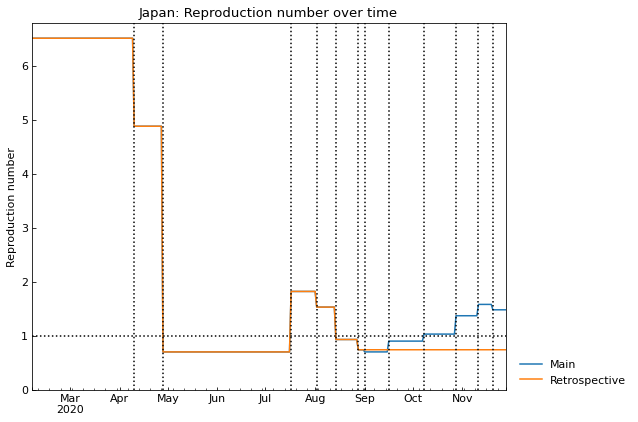

In [48]:
# History of reproduction number
_ = snl_retro.history("Rt")

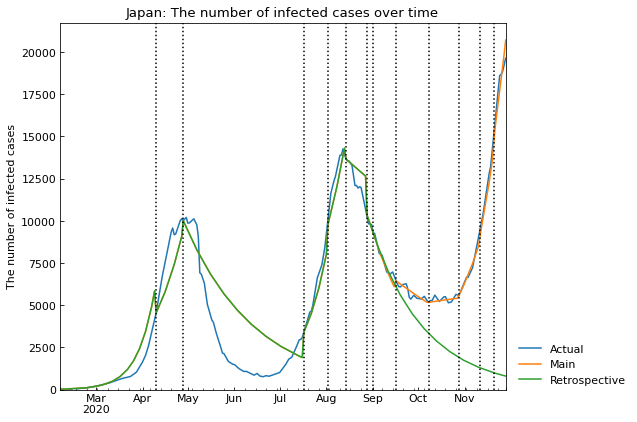

In [49]:
# History of Infected
_ = snl_retro.history("Infected")

In [50]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 29Nov2020,Infected on 29Nov2020,Fatal on 29Nov2020,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,21583,29Nov2020,145807,21583,2054,0.70,0.9,1.03,1.37,1.58,1.48
Retrospective,14309,13Aug2020,92278,784,1940,0.74,-,-,-,-,-
